In [1]:
# uses conda environment gpflow6_0

# generic
import numpy as np
import pandas as pd
import xarray as xr
from itertools import product
import time

# plotting

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D 
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import gpflow as gpf
from gpflow.ci_utils import ci_niter, ci_range
from gpflow.utilities import print_summary

# tensorflow
import tensorflow as tf

#debug
from IPython.core.debugger import set_trace

from eu_functions import *

In [130]:
####################  Initialize parameters #######################

ice_model = "d6g_h6g_"
lith = 'l71C'
tmax = 15000
tmin = 100
agemax = round(tmax, -3) + 100
agemin = round(tmin, -3) - 100
place = 'northsea_uk'

ages = np.arange(agemin, agemax, 100)[::-1]

locs = {
        'northsea_uk': [-10, 10, 45, 60],
        'northsea_uk_tight': [-5, 10, 50, 55],
       }
extent = locs[place]

#import khan dataset
# path = '../data/HOLSEA_2019_uknorthsea.csv'
path = '../../data/GSL_LGM_120519_.csv'
df_place = import_rsls(path, tmin, tmax, extent)

# # add zeros at present-day.  
# nout = 50
# df_place = add_presday_0s(df_place, nout)

#####################  Make xarray template  #######################

filename = '../data/xarray_template.mat'
ds_template = xarray_template(filename, ages, extent)

#####################    Load GIA datasets   #######################

ds = make_mod(ice_model, lith, ages, extent)

likelist = []
namelist = []
wrsslist = []
rmselist = []
wrmselist = []

ds_load = ds.load().chunk((-1,-1,-1)).interp(lon=ds_template.lon, lat=ds_template.lat).to_dataset()

In [ ]:
#####################    Run Iterative GP Regression   ##################


for i, ds_single in ds_load.groupby('modelrun'):

    #interpolate/select priors from GIA model
    df_place['rsl_giaprior'] = df_place.apply(lambda row: ds_select(ds_single, row), axis=1)
    df_place['age_giaprior'] = df_place.apply(lambda row: ds_ageselect(ds_single, row), axis=1)
    
    #calculate residuals
    df_place['rsl_realresid'] = df_place.rsl - df_place.rsl_giaprior
    df_place['age_realresid'] = df_place.age - df_place.age_giaprior
    
    # Calculate weighted root mean squared error and weighted residual sum of squares
    df_place['wrss'] = (df_place.age_realresid/df_place.age_er)**2 + (df_place.rsl_realresid/df_place.rsl_er)**2
    
    wrss = df_place.wrss.sum()
    
    weights = df_place.rsl_er/df_place.rsl_er.sum()
    rmse = np.sqrt((df_place.rsl_realresid ** 2).sum()/len(df_place))
    wrmse = np.sqrt((df_place.rsl_realresid ** 2/weights).sum()/len(df_place))

    
    print('number of datapoints = ', df_place.shape)
    
    ##################	  RUN GP REGRESSION 	#######################
    ##################  --------------------	 ######################


    k1 = 2500
    k2 = 10000
    k3 = 100
    k4 = 6000

    iterations = 1000
    nout = 40
    name = ds_single.modelrun.values.tolist()[0]

    ds_giapriorinterp, da_zp, ds_priorplusgpr, ds_varp, loglike, m = run_gpr(nout, iterations, ds_single, ages, k1, k2, k3, k4, df_place)
    likelist.append(loglike)
    namelist.append(name)
    wrsslist.append(wrss)
    rmselist.append(rmse)
    wrmselist.append(wrmse)
    
    path_gen = f'output/{place}_{name}_{ages[0]}_{ages[-1]}'
    da_zp.to_netcdf(path_gen + '_dazp')
    ds_giapriorinterp.to_netcdf(path_gen + '_giaprior')
    ds_priorplusgpr.to_netcdf(path_gen + '_posterior')
    ds_varp.to_netcdf(path_gen + '_gpvariance')
    
df_out = pd.DataFrame({'modelrun': namelist,
             'log_marginal_likelihood': likelist,
                      'weighted residual sum of squares': wrsslist,
                      'root mean squared error': rmselist,
                      'weighted root mean squared error': wrmselist})


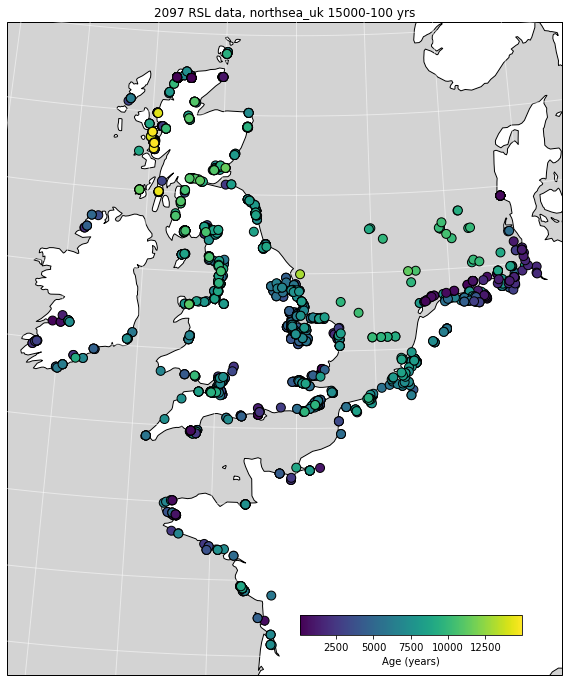

In [131]:
projection = ccrs.LambertConformal(central_longitude=0)
trans = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=projection))

ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

ax.add_feature(ocean_50m, color='lightgray', zorder=0)
ax.add_feature(land_50m, color='white', zorder=1)
ax.gridlines(linewidth=1, color='white', alpha=0.5, zorder=4)
ax.coastlines(resolution='50m')

# ax.set_extent([-10, 10, 45, 60])
# ax.set_extent([-5, 10, 50, 55])

scat = ax.scatter(df_place.lon, df_place.lat, s=80, c = df_place.age, 
                  cmap='viridis', edgecolor='k', linewidths=1, 
                  transform=trans, zorder=5)

cbaxes = inset_axes(ax, width="40%", height="3%", loc=4, borderpad=4,) 
cbar = fig.colorbar(scat, ax=ax, cax=cbaxes, shrink=.5,
                    label='Age (years)', 
                   orientation='horizontal')

ax.set_title(f'{len(df_place)} RSL data, {place} {tmax}-{tmin} yrs');

# fig.savefig('/Users/rogercreel/Desktop/dataplot_fennoscandia')

To Do: 
Make GPR models of all Ice6g, Lev, and Lev + Patton models for this region
for: 

1.  All of data
2.  Regional subsets (SW UK + NW France; Lowlands; Denmark) 
3.  Only data around LIG data constraints (concentric expansions) 

# Visualize outputs

In [123]:
# Load data

ds_varp = xr.open_dataset(glob.glob('output/*variance')[0])
ds_zp = xr.open_dataset(glob.glob('output/*zp')[0]).rename({'__xarray_dataarray_variable__':'rsl'}) #remove when fixed as dataset
ds_giamean = xr.open_dataset(glob.glob('output/*prior')[0])
ds_priorplusgpr = xr.open_dataset(glob.glob('output/*posterior')[0])

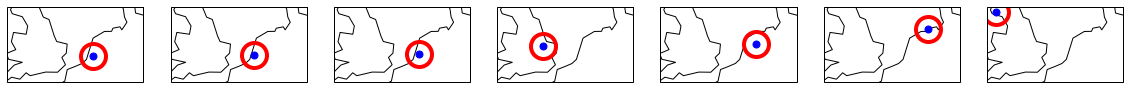

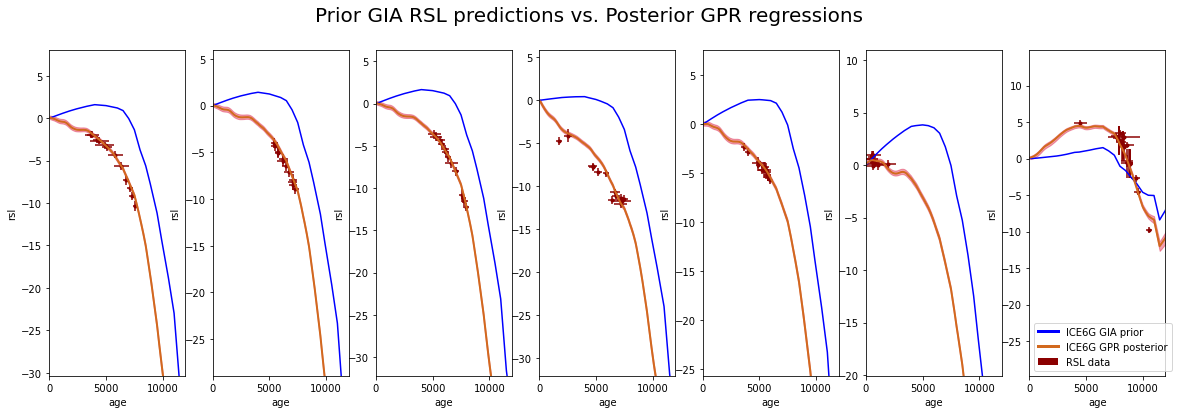

In [124]:
proj = ccrs.PlateCarree()

colormark = ['blue', 'chocolate', 'darkred', 'crimson', 'olivedrab']
cmaps = cmap_codes('viridis', len(df_nufsamps))


number=11

df_nufsamps = locs_with_enoughsamples(df_place, place, number)
nufsamp = df_nufsamps.locnum.unique()

def interp_ds(ds):
    return ds.interp(age=ds_giamean.age, lat=ds_giamean.lat, lon=ds_giamean.lon)

def slice_dataset(ds):
    return ds.rsl.sel(lat=site[1].lat.unique() ,
                  lon=site[1].lon.unique(),
                  method='nearest').sel(age=slice(tmax, tmin))


###### Plot  #####

fig, ax = plt.subplots(1,len(nufsamp), figsize=(20, 6), subplot_kw=dict(projection=projection))
ax = ax.ravel()

da_zeros = xr.zeros_like(ds_giamean.rsl[:,:,0])

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    ax[i].set_extent(extent)
    ax[i].coastlines(color='k')
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=7,
               marker='o',
               transform=trans)
    ax[i].plot(site[1].lon.unique(),
               site[1].lat.unique(),
               c=colormark[0],
               ms=25,
               marker='o',
               transform=trans,
               mfc="None",
               mec='red',
               mew=4)
    da_zeros.plot(ax=ax[i], cmap='Greys', add_colorbar=False)

    ax[i].set_title('')

    
num = 6
fig, ax = plt.subplots(1, len(nufsamp), figsize=(20, 6))
ax = ax.ravel()

for i, site in enumerate(df_nufsamps.groupby('locnum')):
    
    plt.suptitle(f"Prior GIA RSL predictions vs. Posterior GPR regressions", fontsize=20)

#     #slice data for each site
    prior_it = slice_dataset(ds_giamean) 

    post_it = slice_dataset(ds_priorplusgpr)
    var_it = slice_dataset(np.sqrt(ds_varp))
    top = post_it + var_it * 2
    bottom = post_it - var_it * 2
    
    site_err = 2 * (site[1].rsl_er)
    age_err = 2 * site[1].age_er

    prior_it.plot(ax=ax[i], c=colormark[0], alpha=1, label='ICE6G GIA prior')


    ax[i].fill_between(post_it.age, bottom.squeeze(), top.squeeze(), color=colormark[3], alpha=0.4) 
    post_it.plot(ax=ax[i], lw=2, c=colormark[1], alpha=1, label='ICE6G GPR posterior')

    
    ax[i].scatter(site[1].age, site[1].rsl, c=colormark[2], s=4, lw=2,label='RSL data')
    ax[i].errorbar(site[1].age, site[1].rsl, yerr=site_err, xerr=age_err, c=colormark[2], fmt='none', capsize=-.1,lw=1.5)

    ax[i].set_xlim(0, 12000)
    ax[i].set_ylim(site[1].rsl.min() - 20,site[1].rsl.max()+10)
    ax[i].set_title('')
#     if i > num:
#         break

lines = [ Line2D([0], [0], color=colormark[0], linewidth=3, linestyle='-'),
         Line2D([0], [0], color=colormark[1], linewidth=3, linestyle='-'),
         Circle([0], 0.1, color=colormark[2], linewidth=3, ec="none")]

labels = ['ICE6G GIA prior', 'ICE6G GPR posterior', 'RSL data']
ax[i].legend(lines, labels, loc='lower left')


plt.show()